# ART Tutorial 2: Maximize Limonene Production

In this notebook we demonstrate the usage of the Automatic Recommendation Tool (ART) to recommend strain designs for improving limonene production.

In this case we have proteomics data which will be used to determine maximum production of limonene in terms of total protein concentrations. Then target protein concentrations will be reported back to the user.


Tested using **ART Prod** kernel on [skynet.ese.lbl.gov](https://skynet.ese.lbl.gov)

## Inputs and Outputs

#### Required file to run this notebook:
- `Limonene_data_for_ART.csv` file from the `data` directory

#### Files generated by running this notebook:

- a pickle file containing a trained ART object
- a file containing predictive accuracy metrics
- plot of (cross-validated) predictions vs observations for the train data set
- `draws.txt`, containing all draws from the optimization procedure
- `recommendations.csv`, containing the ART recommendations for the next cycle
- plot of predictive distributions for the recommendations
- plot of success probabilities for the recommendations


## Setup

The first step is to make sure the `ART` library is available in your kernel.

Clone the corresponding git repository:


`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`

or pull the latest version.

Information about licensing ART is available at https://github.com/JBEI/ART.



We can then add library to the path and do the necessary import:


In [1]:
import sys
sys.path.append('../')

import warning_utils
warning_utils.filter_end_user_warnings()

In [2]:
from art import utility as utils
from art.core import RecommendationEngine


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## User parameters

Define some of the ART input parameters:

In [3]:
user_params = {
    'data_file': '../data/Limonene_data_for_ART.csv',            # Training data file
    'response_vars': ["Limonene"],     # Response variable
    'input_vars': ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU'], # A list of the relevant input variables (features) to use for model building    ,
    'objective': 'maximize',                                      # Type of the objective
    'threshold': 0.2,                                             # Relative threshold for defining success (e.g. setting to 0.2 means
    # improving the production from the best in the data set by 20% is considered a success)
    'num_recommendations': 10,                                    # Number of recommendations to be provided
    'max_mcmc_cores': 2,
    'cross_val': False,
    'output_dir': '../results/Limonene',                          # Directory to store output files
    'verbose': 1                                                  # Amount of information to be displayed
}

## Load the study data into a dataframe

In [4]:
df = utils.load_study(data_file=user_params['data_file'])

In [5]:
df.head()

,Unnamed: 0,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,0,2843,Principal Component Analysis for Proteomics (P...,2844,768a1508-6a41-4c8e-a61b-0dc271381b07,2X-Mh,DH1 with two plasmid (medium + high copy) expr...,GC-MS,2874,2X-Mh,NaN,Limonene,2,mg/L,75.39261,24.0
1,1,2843,Principal Component Analysis for Proteomics (P...,2845,a810f8d4-4648-4272-a1c5-6dd2200cb8ff,B-Lm,DH1 with single plasmid (medium-copy) expressi...,GC-MS,2875,B-Lm,NaN,Limonene,2,mg/L,12.75786,24.0
2,2,2843,Principal Component Analysis for Proteomics (P...,2846,569fb1c4-3aa1-4209-903d-0bca3acd793f,BL-Mm,DH1 with two plasmid (B + high with extra copy...,GC-MS,2876,BL-Mm,NaN,Limonene,2,mg/L,119.81367,24.0
3,3,2843,Principal Component Analysis for Proteomics (P...,2847,dbebc6b2-ecac-4675-bae3-965080cecb12,2X-Ll,DH1 with two plasmid (medium + high copy) expr...,GC-MS,2877,2X-Ll,NaN,Limonene,2,mg/L,5.98466,24.0
4,4,2843,Principal Component Analysis for Proteomics (P...,2848,8def5195-6d31-493d-bd40-5da7f5c91798,A-Mm,DH1 with single plasmid (high-copy) expression...,GC-MS,2878,A-Mm,NaN,Limonene,2,mg/L,9.66957,24.0


## Running ART to create a predictive model of production and generate recommendations

The first step is to create a dictionary that contains the settings for ART:

In [6]:
art_params = {
    'response_vars': user_params['response_vars'],
    'input_vars': user_params['input_vars'],
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'num_recommendations': user_params['num_recommendations'],
    'seed': 10,
    'cross_val': False,
    'max_mcmc_cores': 2,
    'verbose': user_params['verbose'],
    'output_dir': user_params['output_dir'],
    'last_dashes_denote_replicates': False,
}

The objective is to predict strain designs which will **maximize** production. Successful designs are considered to be those that exceed the maximum observed production by 20%, as specified by the `threshold` variable.


### Run ART

With the configuration stored in `art_params`, we now run ART (this takes ~20min if cross-validation is performed, otherwise it takes ~5min):

Once the model is trained, we use it to find inputs that maximize the limonene production.

ART identified 30 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(ElasticNetCV(input_matrix, l1_ratio=0.05, tol=0.1), l1_ratio=0.45, tol=0.001)
Done fitting L0 models in 3.56 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 16.38 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.097560,0.990360,0.222568,0.059054,0.999956
Random Forest Regressor,7.293367,67.463582,5.508094,83.532310,0.938116
Support Vector Regressor,25.816751,151.889853,28.865585,1499.726588,-0.111063
Kernel Ridge Regressor,12.574144,82.423719,11.951892,300.956820,0.777038
K-NN Regressor,14.385255,102.244064,14.015780,403.377638,0.701160
Gaussian Process Regressor,10.803244,92.259785,10.408810,225.053424,0.833271
Gradient Boosting Regressor,0.103705,1.008630,0.083743,0.017768,0.999987
TPOT Regressor,15.463021,129.415488,12.289935,390.147522,0.710962
Ensemble Model,9.416229,77.191633,8.586845,162.399274,0.879687


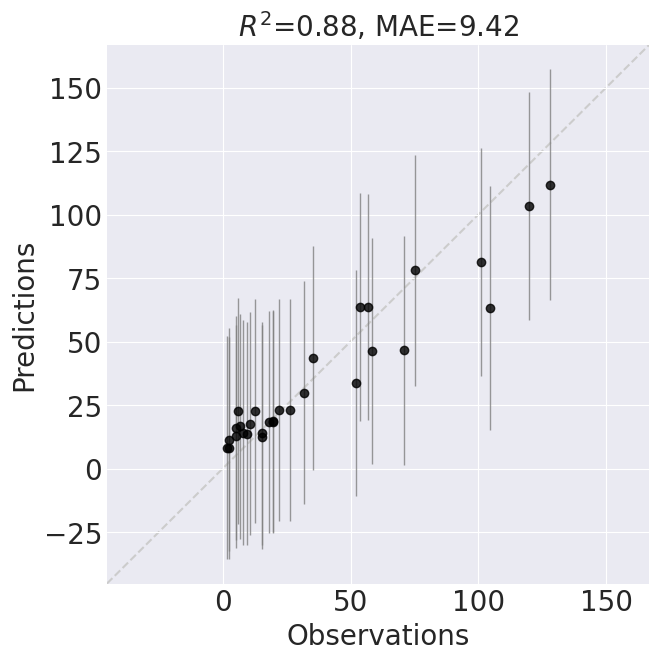

Done building models in 27.91 s
Starting parallel tempering using 2 chains…
Done with parallel tempering in 98.30 s
Choosing recommendations (19,800 candidates)…


Done choosing recommendations in 0.02 s


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.209870,0.192579,2.657573,1.440427,3.829776,14.181569,4.744759,0.434033,0.547618,143.375136
1,0.232119,0.166193,2.622531,1.320874,2.880406,14.165753,4.678024,0.446197,0.564420,143.044397
2,0.236219,0.372326,2.635676,1.301454,2.862588,14.054632,4.743141,0.430983,0.584234,142.829912
3,0.223889,0.144127,2.629328,1.072163,3.934573,14.113308,4.730190,0.423596,0.569345,142.749536
4,0.286747,0.220406,2.212158,1.345364,3.097980,14.183795,4.742433,0.418689,0.564933,142.716044
5,0.215285,0.274906,2.475841,0.955705,2.694736,14.078034,4.707603,0.450889,0.561465,142.684889
6,0.231036,0.135579,2.653142,1.022467,2.790766,14.087485,4.725848,0.503296,0.579391,142.602308
7,0.290962,0.199332,2.664879,1.295937,3.181816,14.106107,4.699166,0.418910,0.567587,142.589561
8,0.218422,0.250748,2.591797,1.237548,3.954499,14.098247,4.713975,0.421278,0.557824,142.576828
9,0.221172,0.450435,2.258026,1.133758,3.167795,14.114874,4.741430,0.450600,0.549515,142.538851


Sampling posterior predictive distributions…


Sampling: [y]


Done sampling in 0.80 s


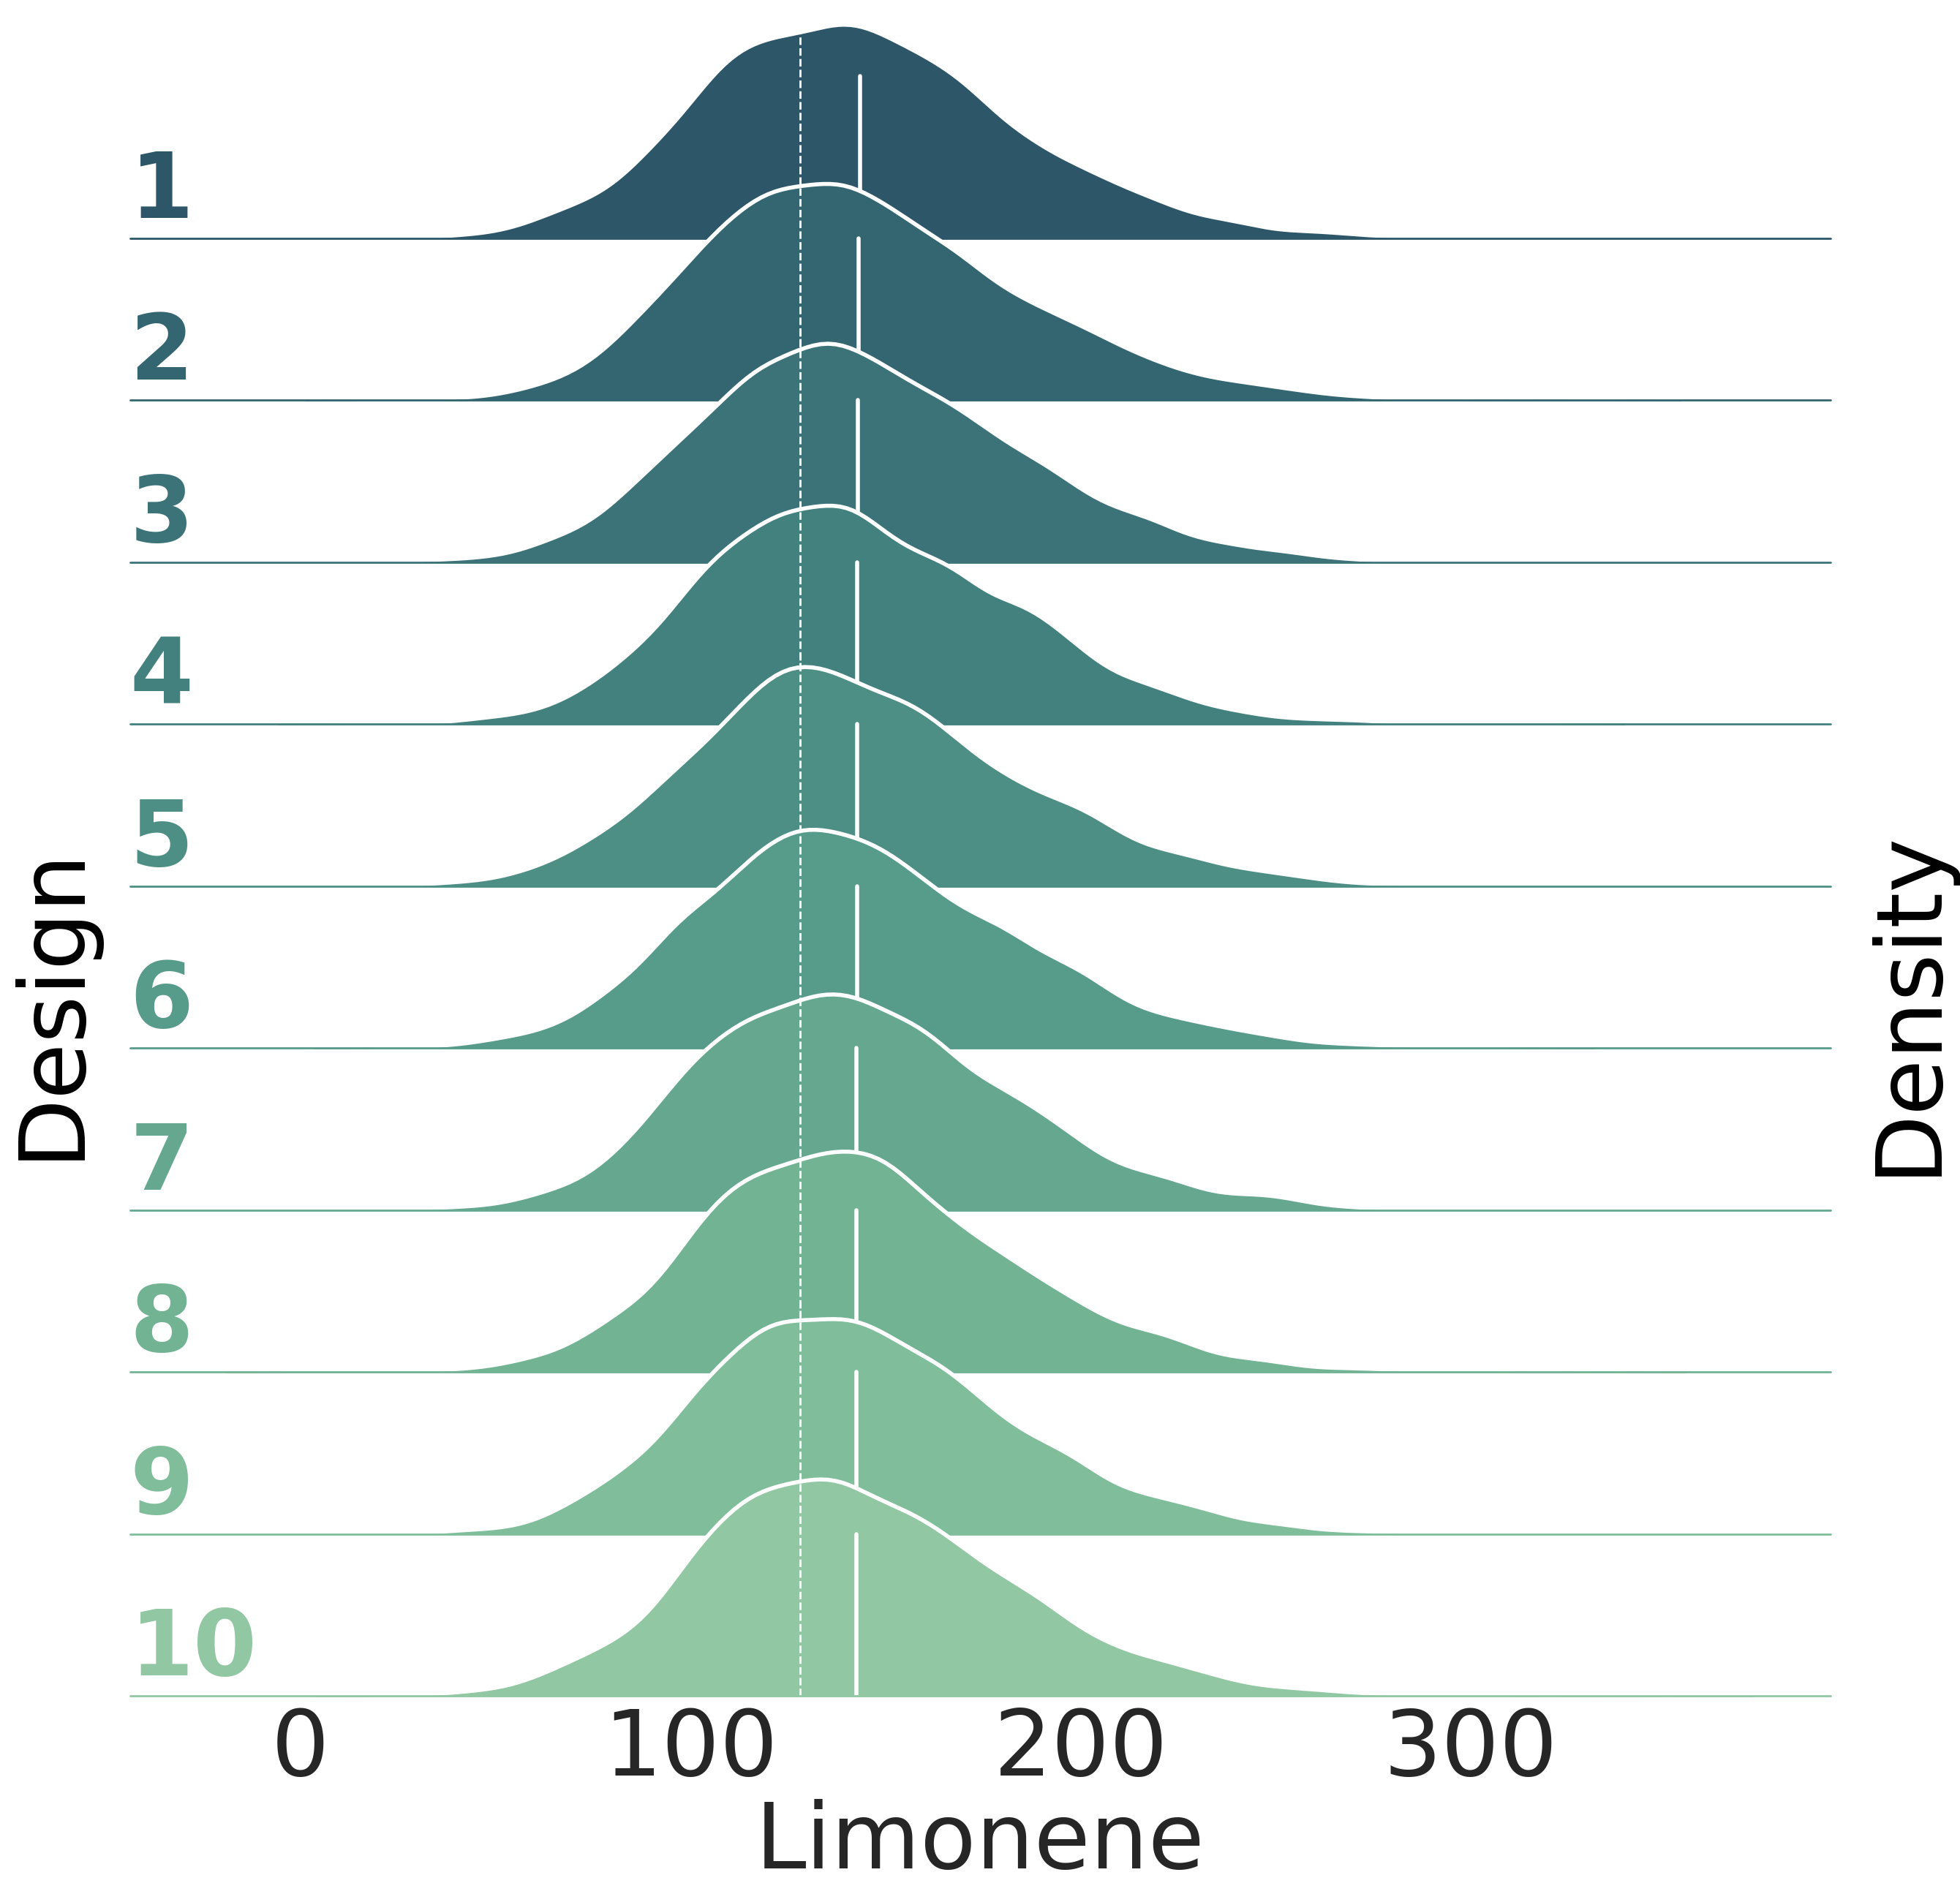

Sampling: [y]


Computing success probabilities…
Sampling posterior predictive distributions…
Done sampling in 0.67 s
Done computing success probabilities in 0.67 s


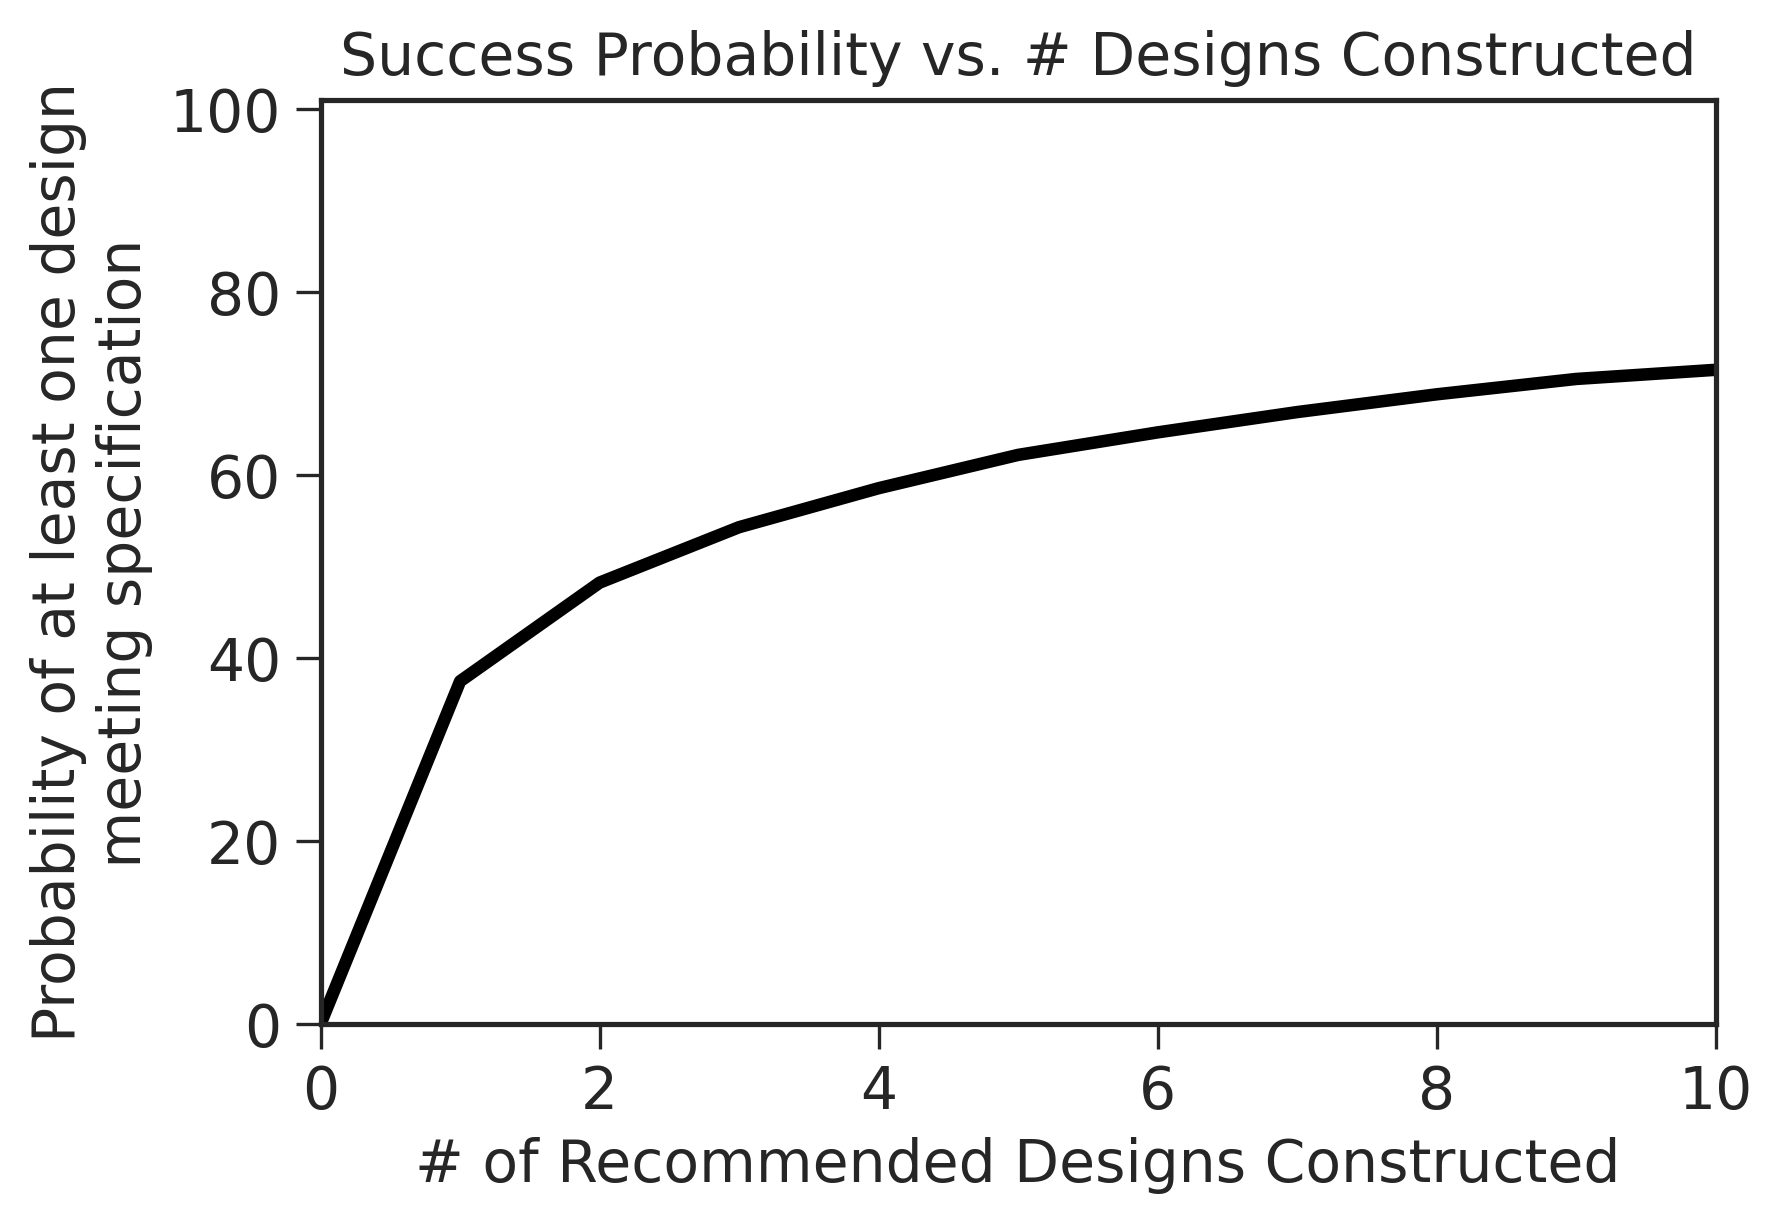

CPU times: user 18.2 s, sys: 1.09 s, total: 19.3 s
Wall time: 2min 11s


In [7]:
%%time
art = RecommendationEngine(df=df, **art_params)


In [8]:
art.save()